In [25]:
# !pip install umap-learn

time: 0 ns (started: 2022-05-06 19:22:02 -04:00)


In [1]:
import pandas as pd
from sklearn.cluster import KMeans, Birch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community
import umap
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout  # requires python-graphviz and pygraphviz
import seaborn as sns
import pickle
%matplotlib inline
%load_ext autotime

def graphSummary(G):
    print("Number of nodes - {}".format(G.number_of_nodes()))
    print("Number of edges - {}".format(G.number_of_edges()))
    print("Density - {}".format(nx.density(G)))

time: 0 ns (started: 2022-05-08 13:26:27 -04:00)


### Data Files

In [2]:
user_embeddings = 'data/web-redditEmbeddings-users.csv'
subreddit_embeddings = 'data/web-redditEmbeddings-subreddits.csv'
title_hyperlink_network = 'data/soc-redditHyperlinks-title.tsv'
body_hyperlink_network = 'data/soc-redditHyperlinks-body.tsv'
columns = ['name'] + [str(i) for i in range(1,301)]

time: 0 ns (started: 2022-05-08 13:26:28 -04:00)


In [77]:
df_subreddit_embeddings = pd.read_csv(subreddit_embeddings,header=None,names=columns)
df_subreddit_embeddings = df_subreddit_embeddings.set_index('name')

time: 1.56 s (started: 2022-05-08 14:23:38 -04:00)


In [5]:
df_network_title = pd.read_csv(title_hyperlink_network, sep='\t')
df_network_body = pd.read_csv(body_hyperlink_network, sep='\t')
# edge_attributes = ['POST_ID', 'TIMESTAMP', 'LINK_SENTIMENT', 'PROPERTIES']
network_title = nx.from_pandas_edgelist(df_network_title, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT',True, create_using=nx.MultiDiGraph)
network_body = nx.from_pandas_edgelist(df_network_body, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT',True, create_using=nx.MultiDiGraph)

time: 18.8 s (started: 2022-05-08 13:26:36 -04:00)


In [137]:
print('Number of subreddits in subreddit word embeddings datafile:',len(df_subreddit_embeddings))

print('\nNetwork-Title:')
graphSummary(network_title)
print('\nNetwork-Body:')
graphSummary(network_body)

Number of subreddits in subreddit word embeddings datafile: 27712

Network-Title:
Number of nodes - 27712
Number of edges - 512808
Density - 0.0006677820223466173

Network-Body:
Number of nodes - 35776
Number of edges - 286561
Density - 0.00022389565198911403
time: 5.17 s (started: 2022-05-08 16:15:42 -04:00)


### Preprocessing
#### There is mismatch in the number of subreddits in the embeddings and network files
#### Remove extra subreddits from Network Files

In [80]:
print(len(df_subreddit_embeddings.index))
print(len(network_title.nodes()))

51278
54075
time: 0 ns (started: 2022-05-08 14:25:58 -04:00)


In [81]:
set1 = set(df_subreddit_embeddings.index) - set(network_title.nodes())
set2 = set(network_title.nodes())- (set(network_title.nodes()) - set(df_subreddit_embeddings.index))
print(len(set1))
print(len(set2))

23566
27712
time: 47 ms (started: 2022-05-08 14:26:00 -04:00)


In [82]:
df_subreddit_embeddings_ = df_subreddit_embeddings.drop(list(set1))
network_title_ = network_title.subgraph(df_subreddit_embeddings_.index)

time: 94 ms (started: 2022-05-08 14:26:04 -04:00)


In [83]:
set1 = set(df_subreddit_embeddings_.index) - set(network_title_.nodes())
set2 = (set(network_title_.nodes()) - set(df_subreddit_embeddings_.index))
print(len(set1))
print(len(set2))

0
0
time: 63 ms (started: 2022-05-08 14:26:07 -04:00)


In [84]:
print(len(df_subreddit_embeddings_.index))
print(len(network_title_.nodes()))

27712
27712
time: 31 ms (started: 2022-05-08 14:26:10 -04:00)


In [85]:
# Final count of subreddits/nodes
df_subreddit_embeddings = df_subreddit_embeddings_
network_title = network_title_
print(len(df_subreddit_embeddings.index))
print(len(network_title.nodes()))

27712
27712
time: 15 ms (started: 2022-05-08 14:26:18 -04:00)


## Find Similar Groups(Community) of Subreddits
#### Using K-Means
##### Finding a good value of k  using Elbow Method

In [126]:
numClusters = [10,40,100,250,500,1000,2000]
SSE = []
for k in numClusters:
    print(k)
    k_means = KMeans(n_clusters=k)
    k_means.fit(df_subreddit_embeddings)
    SSE.append(k_means.inertia_)

10
40
100
250
500
1000
2000
time: 17min 11s (started: 2022-05-08 15:04:20 -04:00)


Text(0, 0.5, 'SSE')

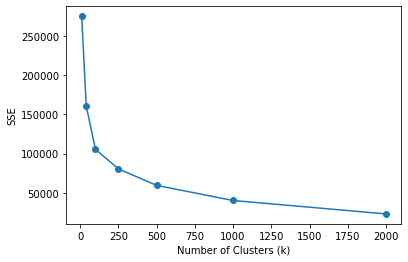

time: 453 ms (started: 2022-05-08 15:33:22 -04:00)


In [127]:
plt.plot(numClusters, SSE,'-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')

#### Finding clusters using k-means with k=100

In [86]:
kmeans = KMeans(n_clusters=100, random_state=123)
kmeans.fit(df_subreddit_embeddings)
df_subreddit_embeddings['labels'] = kmeans.labels_
community_size = Counter(df_subreddit_embeddings.labels)

time: 31.8 s (started: 2022-05-08 14:26:43 -04:00)


##### See subreddits in a particular community

In [87]:
for s in df_subreddit_embeddings[df_subreddit_embeddings['labels']==18].index:
    print(s)

digitalpainting
cfl
alternativeart
imaginarymonsters
adamcarolla
ads
korrasami
dank_meme
imaginarycharacters
imaginarylandscapes
creepypasta
elsanna
sunsetshimmer
gamingnews
tankporn
ploungeafterdark
crossview
wrasslin
ronandfez
equestriagirls
imaginarywesteros
sketches
artistlounge
mlptunes
specart
battlebots
creepyreadings
frozenfriends
imaginarytechnology
undertalecringe
ytp
imaginaryjedi
musicgifstation
imaginarymindscapes
gakinotsukai
sonatadusk
mlpdrawingschool
httyd
subscriptionboxes
bakedart
falloutequestria
mlpanalysis
imaginarycityscapes
conceptart
imaginarydragons
darkjedibrotherhood
artbuddy
imaginarywarhammer
redditpolish
imaginaryleviathans
fanart
harleyquinn
deviantart
vore
charactercrossovers
adagiodazzle
rule34pinups
supersentai
imaginaryhorrors
stevenuniversensfw
tppkappa
princessluna
unusualart
celestia
indiewrestling
undertail
imaginaryboners
geisha
ariablaze
wredditcountryclub
weakendgunnit
mecha
imaginarystarscapes
best_tattoos
afol
armoredwomen
bighero6
ponyplush

##### Subreddit to community(cluster) mapping

In [88]:
subredditToCommunity={}
for row in df_subreddit_embeddings.iterrows():
    subredditToCommunity[row[0]] = int(row[1].labels)

time: 828 ms (started: 2022-05-08 14:27:28 -04:00)


In [489]:
subredditToCommunity

{'spiders': 9,
 'askreddit': 12,
 'globaloffensivetrade': 83,
 'fireteams': 76,
 'funny': 9,
 'the_donald': 70,
 'videos': 34,
 'news': 29,
 'leagueoflegends': 51,
 'rocketleagueexchange': 66,
 'pics': 87,
 'showerthoughts': 12,
 'gaming': 7,
 'aww': 87,
 'adviceanimals': 9,
 'dirtypenpals': 39,
 'globaloffensive': 36,
 'worldnews': 29,
 'dirtykikpals': 39,
 'pcmasterrace': 81,
 'music': 84,
 'politics': 29,
 'dota2': 98,
 'spam': 95,
 'trees': 57,
 'explainlikeimfive': 12,
 'buildapc': 81,
 'destinythegame': 65,
 'movies': 25,
 'gonewild': 22,
 'betternews': 95,
 'todayilearned': 12,
 'overwatch': 31,
 'me_irl': 20,
 'business': 90,
 'hearthstone': 51,
 'technology': 61,
 'askscience': 12,
 'squaredcircle': 49,
 'mildlyinteresting': 9,
 'nba': 60,
 'hiphopheads': 32,
 'politic': 95,
 'wtf': 9,
 'fifa': 68,
 'gifs': 34,
 'soccer': 30,
 'jailbreak': 53,
 'techsupport': 41,
 'jokes': 12,
 'wow': 31,
 'india': 94,
 '2007scape': 88,
 'conspiracy': 70,
 'relationships': 57,
 'pokemontrades'

time: 31 ms (started: 2022-05-08 12:43:08 -04:00)


#### Visualizing Clusters using UMAP for dimensionality reduction

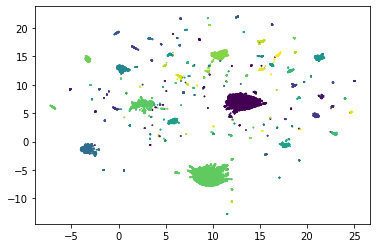

time: 18 s (started: 2022-05-08 14:28:16 -04:00)


In [94]:
df_subreddit_embeddings_reduced = umap.UMAP().fit(df_subreddit_embeddings[df_subreddit_embeddings.columns[:-1]], df_subreddit_embeddings.labels).transform(df_subreddit_embeddings[df_subreddit_embeddings.columns[:-1]])
plt.scatter(df_subreddit_embeddings_reduced[:, 0], df_subreddit_embeddings_reduced[:, 1], c=df_subreddit_embeddings.labels, s=0.5);

## Sentiment Interaction per subreddit
#### Find incoming and outgoing nonnegative and negative links for each subreddit

In [90]:
# [subreddit_name, #nonneg_out_edges, #negative_out_edges, #nonneg_in_edges, #negative_in_edges]
subreddits = []
communityInLinks = []
for i in range(0,100):
    communityInLinks.append([i,0,0,0,0])

G = network_title
for i in G.nodes:
    out_nonneg=0
    out_negative=0
    in_nonneg=0
    in_negative=0
    
    comm_nonneg_same=0
    comm_nonneg_diff=0
    comm_neg_same=0
    comm_neg_diff=0
    
    for u,v,k in G.out_edges(i, data=True):
        if k['LINK_SENTIMENT'] == 1:
            out_nonneg = out_nonneg + 1
        else:
            out_negative = out_negative + 1
    for u,v,k in G.in_edges(i, data=True):
        if k['LINK_SENTIMENT'] == 1:
            in_nonneg = in_nonneg + 1
            if subredditToCommunity[u] == subredditToCommunity[v]:
                comm_nonneg_same=comm_nonneg_same+1
            else:
                comm_nonneg_diff=comm_nonneg_diff+1
        else:
            in_negative = in_negative + 1
            if subredditToCommunity[u] == subredditToCommunity[v]:
                comm_neg_same=comm_neg_same+1
            else:
                comm_neg_diff=comm_neg_diff+1
    
    subreddits.append([i,subredditToCommunity[i],out_nonneg,out_negative,in_nonneg,in_negative])
    comm_ = communityInLinks[subredditToCommunity[i]]
    comm_[1] = comm_[1] + comm_nonneg_same
    comm_[2] = comm_[2] + comm_nonneg_diff
    comm_[3] = comm_[3] + comm_neg_same
    comm_[4] = comm_[4] + comm_neg_diff
    
    communityInLinks[subredditToCommunity[i]] = comm_

time: 4.72 s (started: 2022-05-08 14:27:52 -04:00)


In [118]:
communityInLinksDf = pd.DataFrame(communityInLinks, columns=['commId','nonneg_same','nonneg_diff','neg_same','neg_diff'])
communityInLinksDf['neg_total'] = communityInLinksDf.neg_same+communityInLinksDf.neg_diff
communityInLinksDf['neg_ratio'] = communityInLinksDf.neg_same / communityInLinksDf.neg_total
communityInLinksDf.nlargest(20,'neg_ratio')

,commId,nonneg_same,nonneg_diff,neg_same,neg_diff,neg_total,neg_ratio
10,10,1254,1244,125,92,217,0.576037
58,58,1697,4035,185,285,470,0.393617
64,64,2755,8931,901,2249,3150,0.286032
16,16,1535,3786,80,203,283,0.282686
37,37,781,1931,66,176,242,0.272727
11,11,701,3287,67,225,292,0.229452
34,34,392,813,40,143,183,0.218579
45,45,652,3058,55,248,303,0.181518
52,52,149,534,12,58,70,0.171429
97,97,247,1886,38,195,233,0.163090


time: 0 ns (started: 2022-05-08 14:36:13 -04:00)


In [119]:
communityInLinksDf[communityInLinksDf.neg_same > communityInLinksDf.nonneg_same]

,commId,nonneg_same,nonneg_diff,neg_same,neg_diff,neg_total,neg_ratio
88,88,0,798,1,45,46,0.021739


time: 0 ns (started: 2022-05-08 14:40:45 -04:00)


In [92]:
subredditsDf = pd.DataFrame(subreddits, columns=['name','commId','out_nonneg','out_neg','in_nonneg','in_neg'])
subredditsDf

,name,commId,out_nonneg,out_neg,in_nonneg,in_neg
0,xboxone,24,357,7,630,62
1,battlefield_4,24,78,3,144,16
2,ps4,24,344,6,565,73
3,fitnesscirclejerk,3,2681,598,66,18
4,leangains,77,19,1,22,3
...,...,...,...,...,...,...
27707,eurofighterworld,75,1,0,0,0
27708,tabz,75,0,0,0,0
27709,condimentpackets,75,1,0,0,0
27710,danger5,0,1,0,0,0


time: 46 ms (started: 2022-05-08 14:27:57 -04:00)


## Evaluate sentiment of interaction within community
Within each community
1. Find Sentiment of interaction between subreddits

In [93]:
intraCommunityInteraction = []

# Go through every community
for i in range(0,100):
    subreddits=df_subreddit_embeddings[df_subreddit_embeddings['labels'] == i].index.tolist()
    
    # Create subgraph of community
    G=network_title.subgraph(subreddits)
    community = {}
    # For each edge
    for u,v,k in G.edges(subreddits, data=True):
        sentiment = k['LINK_SENTIMENT']

        # subreddit pair
        key = u+'-'+v

        if key not in community:
            community[key] = [0,0]

        # Add sentiment 
        if sentiment == 1:
            community[key][0] = community[key][0] + 1
        else:
            community[key][1] = community[key][1] + 1
    intraCommunityInteraction.append(community)


time: 1.3 s (started: 2022-05-08 14:28:05 -04:00)


In [96]:
threshold = 2

time: 0 ns (started: 2022-05-08 14:28:46 -04:00)


In [97]:
intraCommunityInteractionDf = []
for i,community in enumerate(intraCommunityInteraction):
    for subredditpair in community.keys():
        communityEntry = [i,subredditpair,community[subredditpair][0],community[subredditpair][1]]
        intraCommunityInteractionDf.append(communityEntry)
intraDf = pd.DataFrame(intraCommunityInteractionDf, columns=['communityId','src_tar','nonneg','neg'])
intraDf['total'] = intraDf.nonneg+intraDf.neg

time: 15 ms (started: 2022-05-08 14:28:49 -04:00)


In [98]:
# Subreddits with more negative links than nonneg towards a subreddit
intraDf[(intraDf.neg>intraDf.nonneg) & (intraDf.neg>threshold)]

,communityId,src_tar,nonneg,neg,total
3365,20,bakchodi-australia,3,4,7
4755,37,nbacirclejerk-torontoraptors,4,5,9
5302,43,wtf-todayilearned,2,3,5
6551,53,botsrights-jesuschristreddit,2,3,5
6559,53,botsrights-theydidthefuckyou,1,6,7
6592,53,botsrights-wackytictacs,1,9,10
6593,53,botsrights-uwotm8,2,5,7
7307,55,bad_religion-trueatheism,0,3,3
7954,64,subredditdrama-wisconsin,4,5,9
8105,64,drama-againstmensrights,0,3,3


time: 16 ms (started: 2022-05-08 14:28:52 -04:00)


In [99]:
# Subreddits with negative links towards a subreddit
intraDf[intraDf.neg>threshold]

,communityId,src_tar,nonneg,neg,total
713,1,tf2shitposterclub-truetf2,8,3,11
730,3,fitnesscirclejerk-weakpots,13,5,18
930,5,nofap-sex,7,4,11
936,5,drugs-trees,9,3,12
968,5,childfree-relationships,25,6,31
...,...,...,...,...,...
11673,87,uwaterloo-uoft,23,4,27
11706,87,infp-intp,5,3,8
12146,97,undertale-jontron,2,3,5
12168,97,jontron-gravityfalls,2,3,5


time: 0 ns (started: 2022-05-08 14:28:54 -04:00)


2. Count subreddits involved in conflicts

In [120]:
# Subreddit pairs in conflict within community
for i,community in enumerate(intraCommunityInteraction):
    for subredditpair in community.keys():
        reverseKey=subredditpair.split('-')[1]+'-'+subredditpair.split('-')[0]
        if community[subredditpair][1] > community[subredditpair][0] and community[subredditpair][1] >= threshold and reverseKey in community.keys():
            print(i, subredditpair, community[subredditpair],'|',reverseKey, community[reverseKey])

9 european-socialism [0, 2] | socialism-european [2, 1]
17 pokemongoyellow-pokemongomystic [1, 2] | pokemongomystic-pokemongoyellow [1, 0]
20 canada-islam [0, 2] | islam-canada [2, 0]
20 unitedkingdom-australia [0, 2] | australia-unitedkingdom [1, 0]
20 pakistan-bakchodi [0, 2] | bakchodi-pakistan [12, 4]
37 rockets-mavericks [1, 2] | mavericks-rockets [2, 0]
37 kcroyals-orioles [0, 2] | orioles-kcroyals [2, 0]
37 phillies-newyorkmets [1, 2] | newyorkmets-phillies [4, 1]
42 dc_cinematic-arrow [0, 2] | arrow-dc_cinematic [1, 0]
43 wtf-todayilearned [2, 3] | todayilearned-wtf [14, 0]
43 firstworldanarchists-mildlyinfuriating [1, 2] | mildlyinfuriating-firstworldanarchists [1, 0]
46 blackout2015-shittheadminssay [0, 2] | shittheadminssay-blackout2015 [4, 0]
59 sydney-melbourne [1, 2] | melbourne-sydney [2, 0]
64 drama-shitamericanssay [1, 2] | shitamericanssay-drama [3, 2]
64 drama-enoughlibertarianspam [2, 3] | enoughlibertarianspam-drama [0, 1]
64 drama-gamerghazi [29, 32] | gamerghazi-

In [101]:
intraDf

,communityId,src_tar,nonneg,neg,total
0,0,darthjarjar-tfaspoilertalk,1,0,1
1,0,darthjarjar-starwarstheories,1,0,1
2,0,danmag-nordvei,2,0,2
3,0,weeklyplanetpodcast-doctorstrange,1,0,1
4,0,flashgames-browsergames,1,0,1
...,...,...,...,...,...
12218,99,newsokuvip-lowlevelaware,1,0,1
12219,99,geinounews-newsg,3,0,3
12220,99,rawchicago-nbastreams,11,0,11
12221,99,rawchicago-mlbstreams,17,0,17


time: 16 ms (started: 2022-05-08 14:29:01 -04:00)


## Evaluate sentiment of interaction between communities
1. Find Negatively interacting communities

In [103]:
allRedditInteraction = {}
indx = df_subreddit_embeddings.index.tolist()
G = network_body
# Go through every subreddit
for u,v,k in G.edges(data=True):
    sentiment = k['LINK_SENTIMENT']
    srcComm = df_subreddit_embeddings.loc[u].labels if u in indx else -1
    tarComm = df_subreddit_embeddings.loc[v].labels if v in indx else -1

    # subreddit pair
    key = u+'-'+v
    if key not in allRedditInteraction:
        allRedditInteraction[key] = [srcComm,tarComm,0,0]
    if sentiment == 1:
        allRedditInteraction[key][2] = allRedditInteraction[key][2] + 1
    else:
        allRedditInteraction[key][3] = allRedditInteraction[key][3] + 1

time: 2min 54s (started: 2022-05-08 14:29:09 -04:00)


In [104]:
allRedditInteractionList = []
for keys in allRedditInteraction.keys():
    allRedditInteractionList.append([keys, int(allRedditInteraction[keys][0]), int(allRedditInteraction[keys][1]),
                                     allRedditInteraction[keys][2], allRedditInteraction[keys][3]])

time: 156 ms (started: 2022-05-08 14:32:04 -04:00)


In [105]:
allInterDf = pd.DataFrame(allRedditInteractionList, columns=['src_tar','srcComm','tarComm','nonneg','neg'])

time: 125 ms (started: 2022-05-08 14:32:04 -04:00)


In [106]:
allInterDf

,src_tar,srcComm,tarComm,nonneg,neg
0,leagueoflegends-teamredditteams,21,21,38,1
1,leagueoflegends-leagueoflegendsmeta,21,89,5,0
2,leagueoflegends-iama,21,71,2,1
3,leagueoflegends-whowouldwin,21,65,2,0
4,leagueoflegends-lolchampconcepts,21,35,21,0
...,...,...,...,...,...
137816,wetclothes-realgirls,-1,7,1,0
137817,wetclothes-gonemild,-1,31,1,0
137818,daddyofive-hatedaddyofive,-1,-1,1,0
137819,noshitouija-ouija_irl,-1,-1,1,0


time: 0 ns (started: 2022-05-08 14:32:04 -04:00)


In [107]:
commToComm = []

# Map subreddit to subreddit interaction sentiment
for i in range(0,100):
    for j in range(0,100):
        subdf = allInterDf[(allInterDf.srcComm == i) & (allInterDf.tarComm == j)]
        nonneg = subdf.nonneg.sum()
        neg = subdf.neg.sum()
        tot = nonneg + neg
        commToComm.append([str(i)+' ('+str(community_size[i])+')',
                           str(j)+' ('+str(community_size[j])+')',
                           nonneg,neg,tot,nonneg/tot, neg/tot])

# Add Reverse mappings
for c2c in commToComm:
    i = int(c2c[0].split(' ')[0])
    j = int(c2c[1].split(' ')[0])
    c2c.extend(commToComm[i + j*100][:7])

C:\Users\disha\AppData\Local\Temp\ipykernel_4820\885922803.py:12: RuntimeWarning: invalid value encountered in longlong_scalars
  nonneg,neg,tot,nonneg/tot, neg/tot])


time: 9.16 s (started: 2022-05-08 14:32:04 -04:00)


In [123]:
commToCommDF = pd.DataFrame(commToComm, columns=['srcComm','tarComm','nonneg','neg','total','nonneg_norm','neg_norm',
                                                'rev_srcComm','rev_tarComm','rev_nonneg','rev_neg','rev_total','rev_nonneg_norm','rev_neg_norm'])
commToCommDF['neg_revneg_ratio'] = commToCommDF.neg/commToCommDF.rev_neg
# commToCommDF = commToCommDF[(commToCommDF.nonneg >= threshold) & (commToCommDF.neg >= threshold)]

# commToCommDF['total'] = commToCommDF.nonneg+commToCommDF.neg
# commToCommDF['nonneg_norm'] = commToCommDF.nonneg/commToCommDF.total
# commToCommDF['neg_norm'] = commToCommDF.neg/commToCommDF.total

time: 47 ms (started: 2022-05-08 14:54:25 -04:00)


In [122]:
commToCommDF[['srcComm','tarComm','nonneg','neg']].nlargest(50,'neg')

,srcComm,tarComm,nonneg,neg
7171,71 (52),71 (52),2624,356
7143,71 (52),43 (24),1853,332
6464,64 (48),64 (48),829,304
505,5 (37),5 (37),1412,225
6443,64 (48),43 (24),534,216
6479,64 (48),79 (30),723,215
643,6 (222),43 (24),444,201
6469,64 (48),69 (18),552,194
6471,64 (48),71 (52),613,176
7169,71 (52),69 (18),1021,173


time: 16 ms (started: 2022-05-08 14:49:53 -04:00)


In [124]:
commToCommDF.nlargest(50,'neg_norm')

,srcComm,tarComm,nonneg,neg,total,nonneg_norm,neg_norm,rev_srcComm,rev_tarComm,rev_nonneg,rev_neg,rev_total,rev_nonneg_norm,rev_neg_norm,neg_revneg_ratio
219,2 (14),19 (184),0,1,1,0.0,1.0,19 (184),2 (14),0,0,0,NaN,NaN,inf
406,4 (34),6 (222),0,1,1,0.0,1.0,6 (222),4 (34),16,2,18,0.888889,0.111111,0.500000
570,5 (37),70 (96),0,1,1,0.0,1.0,70 (96),5 (37),0,0,0,NaN,NaN,inf
614,6 (222),14 (6),0,1,1,0.0,1.0,14 (6),6 (222),0,0,0,NaN,NaN,inf
650,6 (222),50 (18),0,1,1,0.0,1.0,50 (18),6 (222),0,0,0,NaN,NaN,inf
810,8 (19),10 (39),0,1,1,0.0,1.0,10 (39),8 (19),2,0,2,1.000000,0.000000,inf
820,8 (19),20 (36),0,1,1,0.0,1.0,20 (36),8 (19),11,1,12,0.916667,0.083333,1.000000
990,9 (32),90 (1),0,1,1,0.0,1.0,90 (1),9 (32),0,0,0,NaN,NaN,inf
1166,11 (133),66 (289),0,1,1,0.0,1.0,66 (289),11 (133),6,0,6,1.000000,0.000000,inf
1219,12 (27),19 (184),0,1,1,0.0,1.0,19 (184),12 (27),0,0,0,NaN,NaN,inf


time: 15 ms (started: 2022-05-08 14:54:28 -04:00)


In [125]:
commToCommDF[(commToCommDF['neg']>10) & (commToCommDF['rev_neg']>10) & ((commToCommDF['neg_norm']>0.15) | (commToCommDF['rev_neg_norm']>0.15))].nlargest(50,'neg_norm')

,srcComm,tarComm,nonneg,neg,total,nonneg_norm,neg_norm,rev_srcComm,rev_tarComm,rev_nonneg,rev_neg,rev_total,rev_nonneg_norm,rev_neg_norm,neg_revneg_ratio
6400,64 (48),0 (5704),75,40,115,0.652174,0.347826,0 (5704),64 (48),109,31,140,0.778571,0.221429,1.290323
6456,64 (48),56 (613),23,11,34,0.676471,0.323529,56 (613),64 (48),50,19,69,0.724638,0.275362,0.578947
7464,74 (1809),64 (48),219,104,323,0.678019,0.321981,64 (48),74 (1809),125,34,159,0.786164,0.213836,3.058824
6405,64 (48),5 (37),307,143,450,0.682222,0.317778,5 (37),64 (48),95,15,110,0.863636,0.136364,9.533333
6406,64 (48),6 (222),73,32,105,0.695238,0.304762,6 (222),64 (48),288,84,372,0.774194,0.225806,0.380952
6482,64 (48),82 (46),258,110,368,0.701087,0.298913,82 (46),64 (48),82,22,104,0.788462,0.211538,5.000000
5664,56 (613),64 (48),50,19,69,0.724638,0.275362,64 (48),56 (613),23,11,34,0.676471,0.323529,1.727273
6464,64 (48),64 (48),829,304,1133,0.731686,0.268314,64 (48),64 (48),829,304,1133,0.731686,0.268314,1.000000
6487,64 (48),87 (132),115,41,156,0.737179,0.262821,87 (132),64 (48),84,17,101,0.831683,0.168317,2.411765
6453,64 (48),53 (272),144,51,195,0.738462,0.261538,53 (272),64 (48),119,18,137,0.868613,0.131387,2.833333


time: 16 ms (started: 2022-05-08 14:54:39 -04:00)


In [13]:
color_map = df_subreddit_embeddings[df_subreddit_embeddings['labels'].isin(list(range(5,11)))].labels.tolist()
palette = sns.color_palette(None, 100)
color_map = [palette[x] for x in color_map]

time: 0 ns (started: 2022-05-07 10:53:27 -04:00)


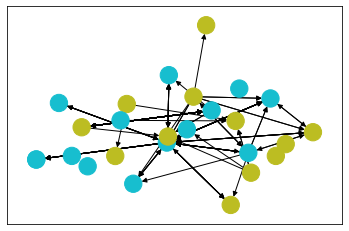

time: 734 ms (started: 2022-05-07 10:53:27 -04:00)


In [16]:
subDf= df_subreddit_embeddings[df_subreddit_embeddings['labels'].isin(list(range(18,20)))]
color_map = subDf.labels.tolist()
palette = sns.color_palette(None, 100)
color_map = [palette[x] for x in color_map]

subG = network_title.subgraph(subDf.index.tolist())
nx.draw_networkx(subG, pos=nx.kamada_kawai_layout(subG), with_labels=False,node_color=color_map )

# Extra

1. For top pairs of interacting subreddits, see the subreddit similarities
2. For different "raids" see user similarities
3. For "raids" between communities, see if posters are bots

In [65]:
G=nx.from_pandas_edgelist(network, 'SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT','LINK_SENTIMENT')

time: 2.02 s (started: 2022-04-14 21:11:44 -04:00)


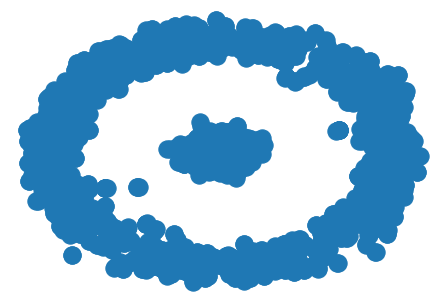

time: 1h 31min 37s (started: 2022-04-14 21:11:55 -04:00)


In [66]:
nx.draw(G)